# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [69]:
import numpy as np
import imageio
import time
import matplotlib.pyplot as plt
from math import pi
%matplotlib inline

/tmp/ipykernel_14783/1561458680.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_14783/1561458680.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961
Size of the inflated map: (1000, 1000)
Occupied Cells: 847020
Free Cells: 152980


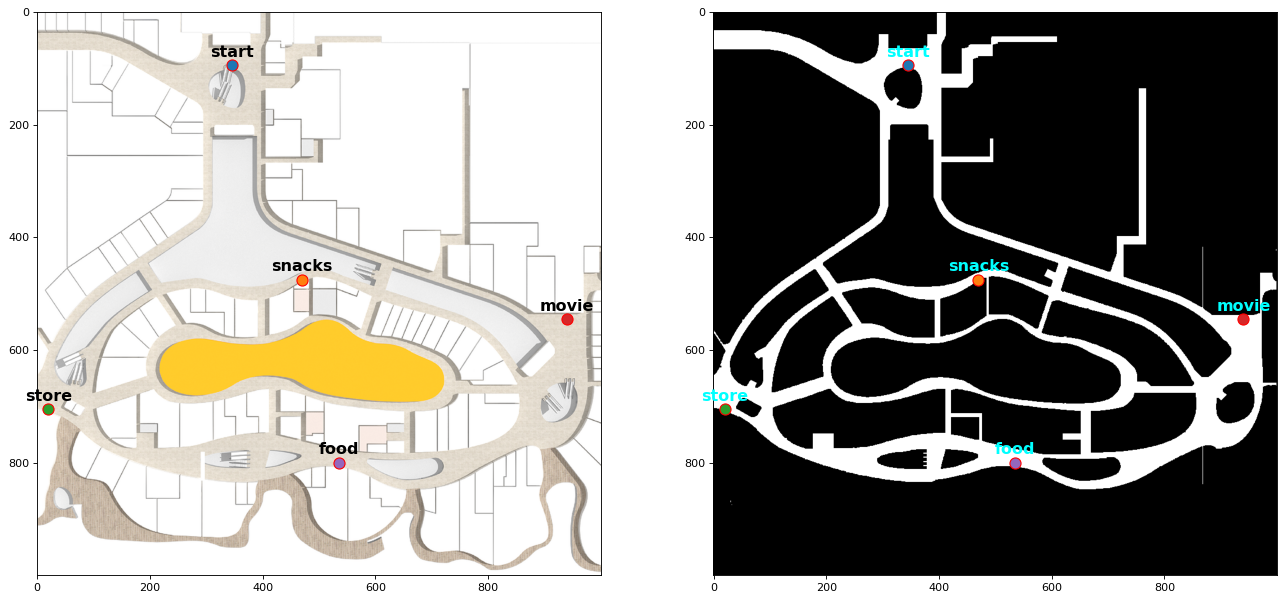

In [70]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map = imageio.imread('./map/vivocity_freespace.png')
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start': [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],  # Garrett Popcorn
             'store': [20, 705],    # DJI Store
             'movie': [940, 545],   # Golden Village
             'food': [535, 800],    # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Preoprocess the map
kernel = np.zeros((3, 3))  # 3x3 kernel for 8-connectivity
inflated_map = np.copy(grid_map)  # create a copy of the map

for i in range(1, len(grid_map)-1):
    for j in range(1, len(grid_map[0])-1):
        if grid_map[i, j] == 0:  # if the pixel is black
            inflated_map[i-1:i+2, j-1:j+2] = np.minimum(inflated_map[i-1:i+2, j-1:j+2], kernel)
inflated_map[0] = 0
inflated_map[:,0] = 0
inflated_map[len(grid_map)-1] = 0
inflated_map[:,len(grid_map)-1] = 0
print("Size of the inflated map:", inflated_map.shape)
print("Occupied Cells:", np.count_nonzero(inflated_map == 0))
print("Free Cells:", np.count_nonzero(inflated_map == 255))

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(inflated_map, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

## Task 1

* Initialize all planners and needed functions. Implemented planner: A*, Hybrid A*, Bidirectional A*, Switch A*, Dijkstra, Greedy best

In [71]:
class AstarPlanner:
    def __init__(self, map, resolution=0.2, connectivity=8, visualization = False):
        self.grid_map = map
        self.resolution = resolution
        self.connectivity = connectivity
        self.visited = None
        self.visualization = visualization

    class node(object):
        def __init__(self, state, g_cost, h_cost, parent):
            self.state = state
            self.g_cost = g_cost
            self.h_cost = h_cost
            self.parent = parent

    def manhatten_distance(self, p1, p2):
        return abs(p1[0]- p2[0]) + abs(p1[1]- p2[1])
    
    def calculate_g(self, p1, p2):
        return self.neighboring_distance(p1, p2)

    def calculate_h(self, current, goal):
        return self.manhatten_distance(current, goal)

    def euclidean_distance(self, p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    def neighboring_distance(self, p1, p2):
        if p1[0] == p2[0] or p1[1] == p2[1]:
            return 1
        else:
            return 1.414

    def is_valid_point(self, point):
        x, y = point
        return 0 <= x < self.grid_map.shape[1] and 0 <= y < self.grid_map.shape[0] and self.grid_map[y, x] == 255

    def plan(self, start, end):
        self.visited = set()
        start_node = self.node(start, 0, self.manhatten_distance(start, end), None)
        open_list = [start_node]
        if self.visualization:
            plt.imshow(self.grid_map, cmap='gray')
            plt.plot(start[0], start[1], 'ro')
            plt.plot(end[0], end[1], 'go')
            plt.axis('off')
            plt.tight_layout()
        start_time = time.time()
        while open_list:
            current = min(open_list, key=lambda x: x.g_cost + x.h_cost)
            open_list.remove(current)
            if current.state == end:
                print(f"Path found between {start} and {end}.")
                path = [end]
                while current.parent:
                    path.append(current.parent.state)
                    current = current.parent
                path.reverse()
                return path, self.visited, time.time() - start_time
            self.visited.add(current.state)
            if self.visualization:
                plt.plot(current.state[0], current.state[1], "ro")
            neighbors = [(current.state[0] + dx, current.state[1] + dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx != 0 or dy != 0]
            if self.connectivity == 4:
                neighbors = [(x, y) for x, y in neighbors if abs(x - current.state[0]) + abs(y - current.state[1]) <= 1]
            for neighbor in neighbors:
                if self.is_valid_point(neighbor) and neighbor not in self.visited:
                    g = current.g_cost + self.calculate_g(neighbor, current.state)
                    in_open_list = False
                    for node_in_list in open_list:
                        if node_in_list.state == neighbor:
                            in_open_list = True
                            if g < node_in_list.g_cost:
                                node_in_list.g_cost = g
                                node_in_list.parent = current
                            break
                    if not in_open_list:
                        h = self.calculate_h(neighbor, end)
                        neighbor_node = self.node(neighbor, g, h, current)
                        open_list.append(neighbor_node)
                        if self.visualization:
                            plt.plot(neighbor_node.state[0], neighbor_node.state[1], "bo")
            if self.visualization:
                plt.pause(0.001)
        return None, self.visited, 0
    
class hybridAstarPlanner(AstarPlanner):
    def __init__(self, map, connectivity=None, resolution=0.2, max_steering=pi/4, num_steps=20, visualization = False):
        super().__init__(map, resolution, visualization=visualization)
        self.curvature_weight = 0.2
        self.max_steering = max_steering
        self.num_steps = num_steps
    
    class hybrid_node(object):
        def __init__(self, state, x_list, y_list, yaw_list, g_cost, h_cost, parent):
            self.state = state
            self.x_list = x_list
            self.y_list = y_list
            self.yaw_list = yaw_list
            self.g_cost = g_cost
            self.h_cost = h_cost
            self.parent = parent

    def calculate_h(self, current, goal):
        return self.euclidean_distance(current, goal)

    def generate_trajectory(self, x, y, theta, steer, v):
        dt = 0.3 / v
        traj = [(x, y, theta)]
        traj_length = 0
        for i in range(self.num_steps):
            if traj_length > 1.4:
                break
            theta += steer * dt
            x += v * np.cos(theta) * dt
            y += v * np.sin(theta) * dt
            traj_length += v * dt
            traj.append([x, y, theta])
        return traj

    def is_valid_hybrid_node(self, x, y):
        return self.is_valid_point((int(round(x)), int(round(y))))

    def car_cost(self, p1, p2):
        x1, y1, theta1 = p1
        x2, y2, theta2 = p2
        steer = np.arctan2(y2 - y1, x2 - x1) - theta1
        traj = self.generate_trajectory(x1, y1, theta1, steer, 1.0)
        cost = 0
        for i in range(len(traj) - 2):
            p1 = traj[i]
            p2 = traj[i + 1]
            p3 = traj[i + 2]
            # calculate curvature
            dx1 = p1[0] - p2[0]
            dy1 = p1[1] - p2[1]
            dx2 = p2[0] - p3[0]
            dy2 = p2[1] - p3[1]
            if abs(dx1) < 1e-6 and abs(dy1) < 1e-6:
                k1 = 0
            else:
                k1 = 2 * (dx1 * dy2 - dy1 * dx2) / (dx1 ** 2 + dy1 ** 2) ** 1.5
            # add curvature-based cost
            cost += 0.2*self.neighboring_distance((int(round(p1[0])), int(round(p1[1]))),
                                            (int(round(p2[0])), int(round(p2[1])))) + abs(k1) * self.curvature_weight
        return cost

    def plan(self, start, end):
        self.visited = set()
        initial_orientation = np.arctan2(end[1] - start[1], end[0] - start[0])
        start_node = self.hybrid_node((start[0], start[1], int(round(initial_orientation / (pi/12)))*pi/12), [start[0]], [start[1]], [initial_orientation], 0, self.manhatten_distance(start, end), None)
        open_list = [start_node]
        if self.visualization:
            plt.imshow(self.grid_map, cmap='gray')
            plt.plot(start[0], start[1], 'ro', zorder=100)
            plt.plot(end[0], end[1], 'go')
            plt.axis('off')
            plt.tight_layout()
        start_time = time.time()
        while open_list:
            current = min(open_list, key=lambda x: x.g_cost + x.h_cost)
            open_list.remove(current)

            if current.state[0:2] == end:
                print(f"Path found between {start} and {end}.")
                path = [end]
                while current.parent:
                    path.append(current.parent.state[0:2])
                    current = current.parent
                path.reverse()
                return path, self.visited, time.time()-start_time
            self.visited.add(current)
            if self.visualization:
                plt.plot(current.state[0], current.state[1], "ro", zorder=100)
            for steer in [0, -self.max_steering*0.5, self.max_steering*0.5, -self.max_steering, self.max_steering]:
                traj = self.generate_trajectory(current.x_list[-1], current.y_list[-1], current.yaw_list[-1], steer, 1.0)
                for i in range(len(traj)):
                    next_state = (int(round(traj[i][0])), int(round(traj[i][1])), int(round(traj[i][2] / (pi/12)))*pi/12)
                    FLAG = False

                    if not self.is_valid_hybrid_node(next_state[0], next_state[1]):
                        continue
                    next_g_cost = current.g_cost + self.car_cost(traj[0], traj[-1])
                    next_h_cost = self.calculate_h(next_state[0:2], end)
                    next_node = self.hybrid_node(next_state, np.array(traj)[:i,0], np.array(traj)[:i,1], np.array(traj)[:,2], next_g_cost, next_h_cost, current)
                    for node in open_list:
                        if node.state[0:2] == next_state[0:2]:
                            FLAG = True
                            break
                    if FLAG:
                        continue

                    for node in self.visited:
                        if node.state[0:2] == next_state[0:2]:
                            FLAG = True
                            break
                    if FLAG:
                        continue
                    open_list.append(next_node)

                    if self.visualization:
                        plt.plot(next_node.state[0], next_node.state[1], "bo")
                    if self.visualization:
                        plt.plot(np.array(traj)[:,0], np.array(traj)[:,1], "yo", markersize=3)
            if self.visualization:
                plt.pause(0.001)
            # if time.time()-start_time >= 90:
            #     print(f"Run out of time, no path between {start} and {end} found.")
            #     break
        return None, self.visited, 0
    
class bidirectionalAstarPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)
        self.visited_forward = None
        self.visited_backward = None

    def _merge_paths(self, current_forward, concatenated_node):
        """
        Merge the paths found from the two searches.

        Args:
            current_forward (node): Latest node from the forward search.
            concatenated_node (node): Node to be concatenated.

        Returns:
            list: The combined path from start to goal.
            goal: the state of the goal.
        """
        path = [current_forward.state]
        while current_forward.parent:
            current_forward = current_forward.parent
            path.insert(0, current_forward.state)
        current_backward = concatenated_node
        while current_backward.parent:
            current_backward = current_backward.parent
            path.append(current_backward.state)
        return path

    def plan(self, start, end):
        start_node = self.node(start, 0, self.manhatten_distance(start, end), None)
        end_node = self.node(end, 0, self.manhatten_distance(end, start), None)
        self.visited_forward = set()
        self.visited_backward = set()
        self.visitedNode_backward = []
        open_list_forward = [start_node]
        open_list_backward = [end_node]
        if self.visualization:
            plt.imshow(self.grid_map, cmap='gray')
            plt.plot(start[0], start[1], 'ro')
            plt.plot(end[0], end[1], 'go')
            plt.axis('off')
            plt.tight_layout()
        start_time = time.time()
        while open_list_forward and open_list_backward:
            current_forward = min(open_list_forward, key=lambda x: x.g_cost + x.h_cost)
            current_backward = min(open_list_backward, key=lambda x: x.g_cost + x.h_cost)
            for state in self.visited_backward:
                if current_forward.state == state:
                    # path found
                    print(f"Path found between {start} and {end}.")
                    for n in self.visitedNode_backward:
                        if n.state == state:
                            node = n
                    if node.parent is None: # Forwarding directly to the end
                        path = [current_forward.state]
                        while current_forward.parent:
                            path.append(current_forward.parent.state)
                            current_forward = current_forward.parent
                        path.reverse()
                        return path, self.visited_forward.union(self.visited_backward), time.time() - start_time
                    
                    if node.state == start: # Backwarding directly to the start
                        path = [current_backward.state]
                        while current_backward.parent:
                            path.append(current_backward.parent.state)
                            current_backward = current_backward.parent
                        path.reverse()
                        return path, self.visited_forward.union(self.visited_backward), time.time() - start_time
                    
                    concatenated_node = node.parent
                    path = self._merge_paths(current_forward, concatenated_node)
                    return path, self.visited_forward.union(self.visited_backward), time.time()-start_time
                
            open_list_forward.remove(current_forward)
            open_list_backward.remove(current_backward)
            self.visited_forward.add(current_forward.state)
            self.visited_backward.add(current_backward.state)
            self.visitedNode_backward.append(current_backward)
            if self.visualization:
                plt.plot(current_forward.state[0], current_forward.state[1], "ro")
                plt.plot(current_backward.state[0], current_backward.state[1], "ro")

            neighbors_f = [(current_forward.state[0] + dx, current_forward.state[1] + dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx != 0 or dy != 0]
            neighbors_b = [(current_backward.state[0] + dx, current_backward.state[1] + dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx != 0 or dy != 0]

            if self.connectivity == 4:
                neighbors_f = [(x, y) for x, y in neighbors_f if abs(x - current_forward.state[0]) + abs(y - current_forward.state[1]) <= 1]
                neighbors_b = [(x, y) for x, y in neighbors_b if abs(x - current_backward.state[0]) + abs(y - current_backward.state[1]) <= 1]

            for neighbor in neighbors_f:
                if self.is_valid_point(neighbor) and neighbor not in self.visited_forward:
                    g = current_forward.g_cost + self.calculate_g(neighbor, current_forward.state)
                    in_open_list = False
                    for node_in_list in open_list_forward:
                        if node_in_list.state == neighbor:
                            in_open_list = True
                            if g < node_in_list.g_cost:
                                node_in_list.g_cost = g
                                node_in_list.parent = current_forward
                            break
                    if not in_open_list:
                        h = self.calculate_h(neighbor, end)
                        neighbor_node = self.node(neighbor, g, h, current_forward)
                        open_list_forward.append(neighbor_node)

                        if self.visualization:
                            plt.plot(neighbor_node.state[0], neighbor_node.state[1], "bo")

            for neighbor in neighbors_b:
                if self.is_valid_point(neighbor) and neighbor not in self.visited_backward:
                    g = current_backward.g_cost + self.calculate_g(neighbor, current_backward.state)
                    in_open_list = False
                    for node_in_list in open_list_backward:
                        if node_in_list.state == neighbor:
                            in_open_list = True
                            if g < node_in_list.g_cost:
                                node_in_list.g_cost = g
                                node_in_list.parent = current_backward
                            break
                    if not in_open_list:
                        h = self.calculate_h(neighbor, start)
                        neighbor_node = self.node(neighbor, g, h, current_backward)
                        open_list_backward.append(neighbor_node)

                        if self.visualization:
                            plt.plot(neighbor_node.state[0], neighbor_node.state[1], "bo")
            if time.time()-start_time >= 90:
                print(f"Run out of time, no path between {start} and {end} found.")
                break
            if self.visualization:
                plt.pause(0.001)
        return None, self.visited_forward.union(self.visited_backward), 0
    
class switchAstarPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)

    def calc_pathLength(self, path):
        path_length = 0
        for n in range(len(path)):
            if n == len(path)-1:
                break
            path_length += self.neighboring_distance(path[n], path[n+1]) * self.resolution
        return path_length
    
    def plan(self, start, end):
        planner = AstarPlanner(self.grid_map, connectivity=self.connectivity, visualization=self.visualization)
        path, visited, time = planner.plan(start, end)
        path_reverse, visited_reverse, time_reverse = planner.plan(end, start)
        if path is not None:
            l_forward = self.calc_pathLength(path)
            l_reverse = self.calc_pathLength(path_reverse)
        if l_forward > l_reverse:
            return path_reverse, visited_reverse, time + time_reverse
        else:
            return path, visited, time + time_reverse
        
class DijkstraPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)

    def calculate_h(self, current, goal):
        return 0
    
class greedyPlanner(AstarPlanner):
    def __init__(self, map, connectivity, visualization):
        super().__init__(map, connectivity=connectivity, visualization=visualization)

    def calculate_g(self, p1, p2):
        return 0
    
def calc_pathLength(path, planner, resolution=0.2):
    path_length = 0
    for n in range(len(path)):
        if n == len(path)-1:
            break
        path_length += planner.euclidean_distance(path[n], path[n+1]) * resolution
    return path_length

def plan_all_paths(points, planner):
    success = 0
    paths = []
    visited_cells_list = []
    total_time = 0
    distances_total = []
    count = 0
    for i in range(len(points)):
        distances = []
        for j in range(len(points)):
            if i == j:
                distances.append(0)
                continue
            visited_cells = set()
            path, visited, time = planner.plan(points[i], points[j])
            if path is not None:
                success += 1
                path_length = calc_pathLength(path, planner)
                distances.append(round(path_length, 2))
            else:
                count -= 1
                distances.append('-')

            total_time += time
            paths.append(path)
            visited_cells.update(visited)
            count += 1
        visited_cells_list.append(visited_cells)
        distances_total.append(distances)

    avg_time = total_time/count
    total = 0
    c = 0
    for row in distances_total:
        for elem in row:
            if elem != '-' and elem != 0:
                total += elem
                c += 1
    if c == 0:
        average_length = 0
    else:
        average_length = total / c
    success_rate = success/(len(points)**2-len(points))
    return paths, distances_total, visited_cells_list, avg_time, average_length, success_rate

* Begin planning

Path found between (345, 95) and (20, 705).
Path found between (20, 705) and (345, 95).
distance list: [[0, 166.4], [167.75, 0]]
Avg time consumed: 22.48
Avg length of path: 167.08
Success rate: 100.0%


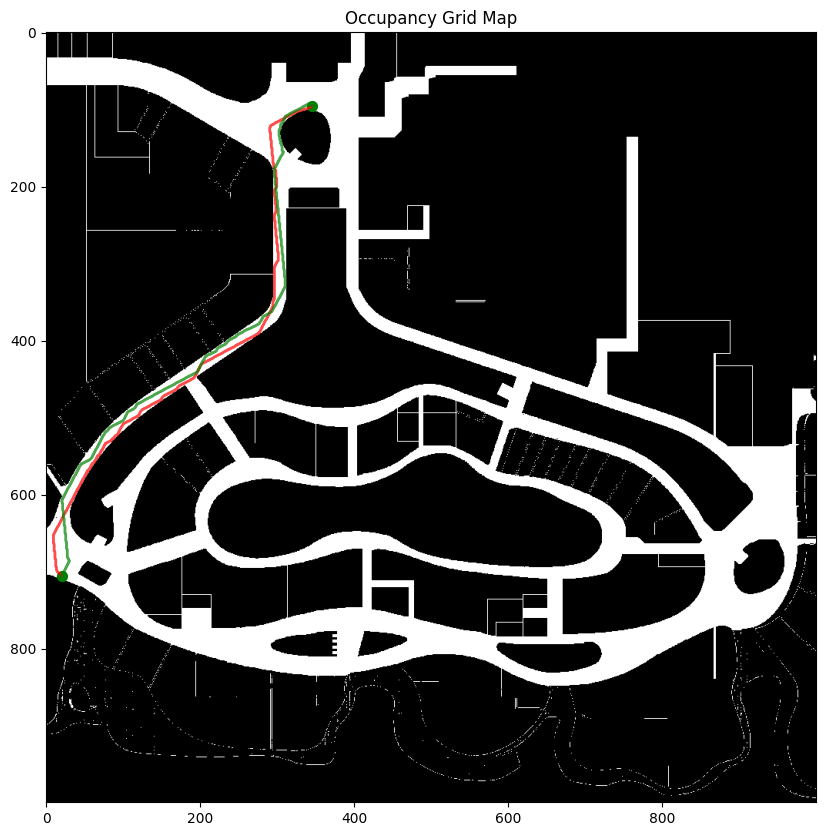

In [72]:
points = [tuple(value) for value in locations.values()]

 # Change the planner here. Implemented planner: AstarPlanner, hybridAstarPlanner, bidirectionalAstarPlanner, switchAstarPlanner,
 # DijkstraPlanner, greedyPlanner
planner = hybridAstarPlanner(inflated_map, connectivity=8, visualization=False)
# points = [points[0], points[2]]
paths, distances_total, visited_cells, avg_time, avg_distance, success_rate = plan_all_paths(points, planner)

print(f"distance list: {distances_total}")
print(f"Avg time consumed: {round(avg_time, 2)}")
print(f"Avg length of path: {round(avg_distance, 2)}")
print(f"Success rate: {100*round(success_rate, 2)}%")

# Visualize the map and paths
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid_map, cmap='gray')

for i, end in enumerate(points):
    ax.scatter(end[0], end[1], c='green', s=50, marker='o')

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, path in enumerate(paths):
    if path is not None:
        path_array = np.array(path)
        ax.plot(path_array[:,0], path_array[:,1], color=colors[i % len(colors)], linewidth=2, alpha=0.7)

ax.set_title('Occupancy Grid Map')
plt.show()

## Task 3